## Constant Proportion Portfolio Insurance (CPPI)

CPPI strategy consists in splitting your assets considering how much money you would _never_ like to lose, which is what we call the **floor**.The difference between the actual value of your assets and this floor multiplied by a factor M would be invested in risky assets, while the remaining would be invested in safe assets.

CPPI strategy requires readjusting our assets constantly, as the proportion of risky and safety assets in our portfolio is based on how much the portfolio is worth at a certain time. If the portfolio is changed in a long enough amount of time (e.g. monthly or quarterly), it might happen that the assets are worth less than the floor. This risk of breaching the floor is called **gap risk**. In general, we say that gap risk materializes if the loss on the risky portfolio relative to the safe portfolio exceeds $\frac{1}{M}$. For this reason, it is a good idea to calibrate M as a function of the maximum potential loss within a given trading interval

### Maximum Drawdown Floor

Maximum drawdown floor is one of the ways in which we can protect our floor. The constraint we have in this case is the following:

$$ V_{t} > \alpha M_{t} $$

where $V_{t}$ is the value of the portfolio at a time t, $M_{t}$ the maximum value of the portfolio between time 0 and t and $1-\alpha$ (not $\alpha$) is the maximum acceptable drawdown.

### Performance Cap

Sometimes, we might also want to establish un upper limit (a cap) to our assets which would also affect the proportion of our risky assets. If we have a performance cap, we should follow the rules below:

$$ F_{t} \leq A_{t} \leq T_{t} \rightarrow E_{t} = m(A_{t} - F_{t}) $$
$$ T_{t} \leq A_{t} \leq C_{t} \rightarrow E_{t} = m(C_{t} - A_{t})$$

What this says is that if our asset values A are between the floor F and a given threshold T, the risky asset allocation should be the difference between the asset value and the floor (multiplied by m), while if the asset value surpasses the threshold, the allocation should me given by the difference between the cap or ceiling C and this threshold (multiplied by m too).

Of course, in order to do this we need to set a threshold, which is done by imposing the "smooth-passing" condition. This is established by doing $A_{t} = T_{t}$. In this case, both equations above form an equality, so if we know $F_{t}$ and $C_{t}$, which we have established beforehand, we can obtain $T_{t}$. In the end, you obtain:

$$T_{t} = \frac{F_{t} + C_{t}}{2}$$

In [19]:
%load_ext autoreload
%autoreload 2

import edhec_risk_kit as erk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
#This part might take a couple of minute, be patient. 

ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

Let's take some industries as our risky assets:

In [21]:
risky_r = ind_return["2000":][["Steel","Fin","Beer"]]



We also need some safe assets that we have to create. First of all, we cant create a DataFrame with the same shape as risky_r while using the following trick:

In [22]:
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r

,Steel,Fin,Beer
2000-01,NaN,NaN,NaN
2000-02,NaN,NaN,NaN
2000-03,NaN,NaN,NaN
2000-04,NaN,NaN,NaN
2000-05,NaN,NaN,NaN
...,...,...,...
2018-08,NaN,NaN,NaN
2018-09,NaN,NaN,NaN
2018-10,NaN,NaN,NaN
2018-11,NaN,NaN,NaN


what we have to do now is calculating the following:

1. Cushion = Asset Value - Floor Value

2. Computing allocation to safe and risky assets ---> M*risk budget (aka cushion)

3. Recompute the asset value based on the returns.

We will do this by using the function "ccp" we created, which returns the cushion, asset value and risk asset weight histories. This function requires us to give a floor and an initial investment. Risk free rate is assumed to be 0.03 annually, and m factor is set to 3, but both parameters can be changed:

In [23]:
backtest_result = erk.cppi(risky_r,0.8,1000,m=3)

Let's now compare the asset value for the Beer and Steel industries following CPPI strategy with the wealth index of a 100% Beer industry portfolio:

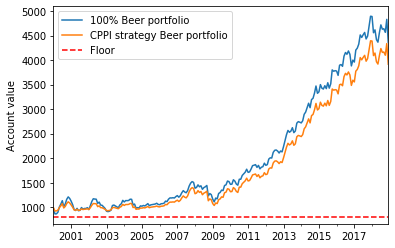

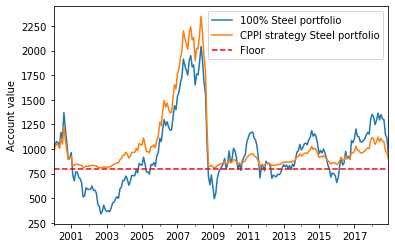

In [24]:
backtest_result["Risky Wealth"]["Beer"].plot(label="100% Beer portfolio",legend=True)
backtest_result["Wealth"]["Beer"].plot(label="CPPI strategy Beer portfolio",legend=True)
plt.ylabel("Account value")
plt.axhline(backtest_result["floor"]*backtest_result["start"],0,1,color="r",linestyle="--",label="Floor")
plt.legend()
plt.show()

backtest_result["Risky Wealth"]["Steel"].plot(label="100% Steel portfolio",legend=True)
backtest_result["Wealth"]["Steel"].plot(label="CPPI strategy Steel portfolio",legend=True)
plt.ylabel("Account value")
plt.axhline(backtest_result["floor"]*backtest_result["start"],color="r",linestyle="--",label="Floor")
plt.legend()
plt.show()

We can extract very useful information from these graphs. As we can see with the Beer industry, when there are no major losses or apparent risk, CPPI might perform slightly worse than a 100% risky asset. However, if we have a look at the Steel portfolio, we can see that CPPI strategy performance is much better when major losses appear, as it reduces exposure to risk. In essence, CPPI strategy returns slightly worse benefits, but this is heavily compensated by the reduction in risk.

It is also interesting to change the m factor and see how the account value changes with it. If you do this, you will see why it is so important to calibrate the m factor.

**I will now introduce a function that summarizes some of the important stats that we need to take into account to analyze the assets. It could be anywhere else, but the course teacher introduced it here**

In [25]:
erk.summarize_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Cornish-Fisher CVaR,Sharpe Ratio
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.220440,-0.102567
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.135900,0.126718
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.094073,0.354314


Let's compute now the stats of the CPPI portfolio. For this, we need the returns, which can be calculated by using the wealth, or value or the account, and the Pandas function pct_change, which returns the percentage change between the current and a prior element (that is, the return).

In [26]:
erk.summarize_stats(backtest_result["Wealth"].pct_change().dropna()) #dropna in case there are NaNs

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Cornish-Fisher CVaR,Sharpe Ratio
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.167464,-0.196750
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.107982,0.080352
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.077163,0.383772


So we can see that the CPPI strategy reduces the VaR and the volatility, which are usually considered risk indicators. In essence, this suggests that CPPI strategy protects you from downside.

Instead of focusing on some industries, let's now have a look at the total market:

In [37]:
backtest_result_market = erk.cppi(tmi_return["2007":],0.8,1000,m=3)

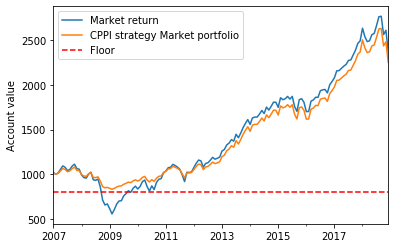

In [45]:
ax = backtest_result_market["Risky Wealth"].plot(label="Market portfolio")
ax.plot(backtest_result_market["Wealth"],label="CPPI strategy Market portfolio")
ax.axhline(backtest_result["floor"]*backtest_result["start"],0,1,color="r",linestyle="--",label="Floor")
ax.set_ylabel("Account value")
ax.legend()

In [30]:
erk.summarize_stats(backtest_result_market["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Cornish-Fisher CVaR,Sharpe Ratio
Market return,0.073411,0.150463,-0.734939,4.523488,0.071592,0.091954,0.280618


In [31]:
erk.summarize_stats(backtest_result_market["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Cornish-Fisher CVaR,Sharpe Ratio
Market return,0.069416,0.100381,-0.588292,3.740932,0.045678,0.062953,0.382052


Again, we can arrive to the same conclusions. If we have a look at the 2009 crash, we can appreciate how well CPPI strategy reduces drawdowns.

### Drawdown constraint

We can improve our strategy if we introduce a dynamic floor value that changes with the drawdown. In order to do this, we can use the same function we had before, but using the "drawdown" parameter.

In [70]:
btr= erk.cppi(ind_return["2007":][["Steel","Fin","Beer"]],init_invest=1000, floor=0.75,drawdown=0.25)

Text(0.5, 1.0, 'Risky assets (continuous) vs CPPI with dynamic floor (dotted)')

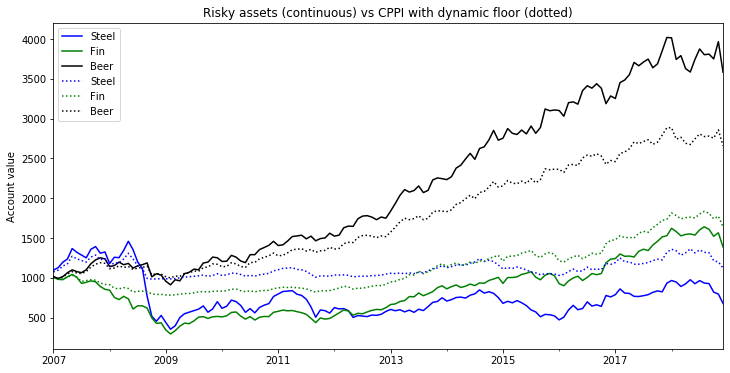

In [75]:
ax = btr["Risky Wealth"].plot(figsize=(12,6),color=["blue","green","black"])
btr["Wealth"].plot(ax=ax,linestyle="dotted",color=["blue","green","black"])
ax.set_ylabel("Account value")
ax.legend()
ax.set_title("Risky assets (continuous) vs CPPI with dynamic floor (dotted)")